### installs and imports

In [48]:
pip install torch torchvision numpy matplotlib Pathlib -qqq


In [49]:

import os
from pathlib import Path
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np
import time
import copy
from urllib.request import urlretrieve
import zipfile


device = torch.device("cuda" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


### Load Dataset from Kaggle

In [50]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Split the data into train val, and test set (starified)

In [51]:
dataset_path = Path(path)

In [52]:
image_paths = []
labels = []

for file_name in os.listdir(dataset_path):
    if file_name.endswith(".png"):
        image_paths.append(Path(dataset_path) / file_name)
        labels.append(int(file_name[1])-1)

print(image_paths[:5])
print(labels[:5])

[PosixPath('/kaggle/input/horse-breeds/01_103.png'), PosixPath('/kaggle/input/horse-breeds/03_068.png'), PosixPath('/kaggle/input/horse-breeds/02_060.png'), PosixPath('/kaggle/input/horse-breeds/03_030.png'), PosixPath('/kaggle/input/horse-breeds/07_065.png')]
[0, 2, 1, 2, 6]


In [53]:


train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels,
    test_size=0.3,        
    stratify=labels,      
    random_state=42      
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels,
    test_size=0.5,       
    stratify=temp_labels,
    random_state=42
)

print(f"Train samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")


Train samples: 469
Validation samples: 100
Test samples: 101


In [54]:
#count how many samples per class in whole dataset
for c in set(labels):
    pct = labels.count(c) / len(labels) * 100
    print(f"Class {c}: {pct:.2f}%")

Class 0: 18.36%
Class 1: 15.67%
Class 2: 15.97%
Class 3: 5.52%
Class 4: 8.36%
Class 5: 18.21%
Class 6: 17.91%


#### ^ Notice that classes are imbalanced. so we will do oversampling later.

#### Check Classes have a balanced split in training and validation samples


In [55]:
print("Train:")
for c in set(train_labels):
    pct = train_labels.count(c) / len(train_labels) * 100
    print(f"Class {c}: {pct:.2f}%")

print("\nValidation:")
for c in set(val_labels):
    pct = val_labels.count(c) / len(val_labels) * 100
    print(f"Class {c}: {pct:.2f}%")

print("\nTest:")
for c in set(test_labels):
    pct = test_labels.count(c) / len(test_labels) * 100
    print(f"Class {c}: {pct:.2f}%")



Train:
Class 0: 18.34%
Class 1: 15.78%
Class 2: 15.99%
Class 3: 5.54%
Class 4: 8.32%
Class 5: 18.12%
Class 6: 17.91%

Validation:
Class 0: 18.00%
Class 1: 15.00%
Class 2: 16.00%
Class 3: 6.00%
Class 4: 9.00%
Class 5: 18.00%
Class 6: 18.00%

Test:
Class 0: 18.81%
Class 1: 15.84%
Class 2: 15.84%
Class 3: 4.95%
Class 4: 7.92%
Class 5: 18.81%
Class 6: 17.82%


### Dataset Class

In [56]:
class HorseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


### Transforms


In [57]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),   
    transforms.RandomHorizontalFlip(),   
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

* Now making datasets with transformation

In [58]:
train_dataset = HorseDataset(train_paths, train_labels, transform=train_transform)
val_dataset   = HorseDataset(val_paths, val_labels, transform=val_transform)
test_dataset  = HorseDataset(test_paths, test_labels, transform=val_transform)



print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 469, Val: 100, Test: 101


#### Displaying images

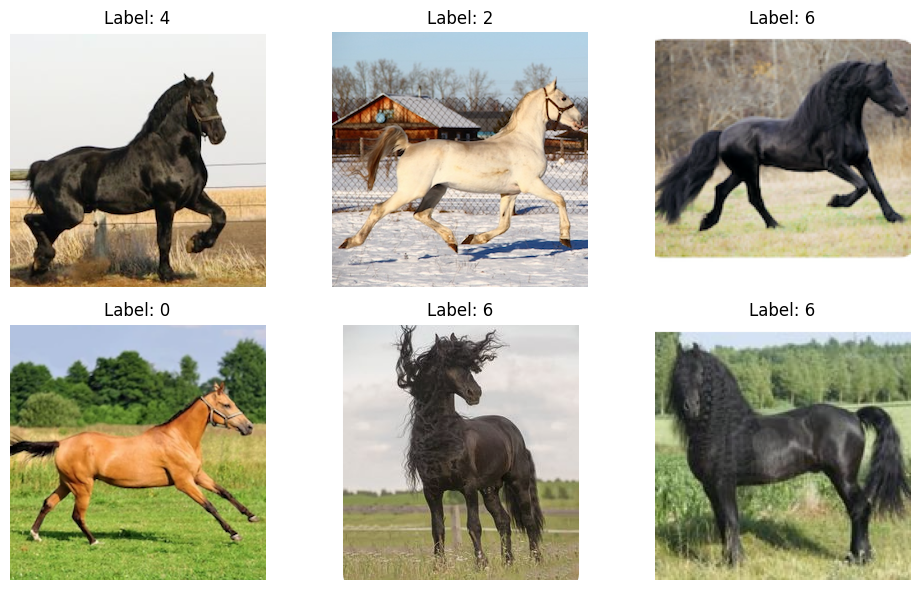

In [59]:

train_original = HorseDataset(train_paths, train_labels)

plt.figure(figsize=(10, 6))

for i in range(6):
    img, label = train_original[i]  
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


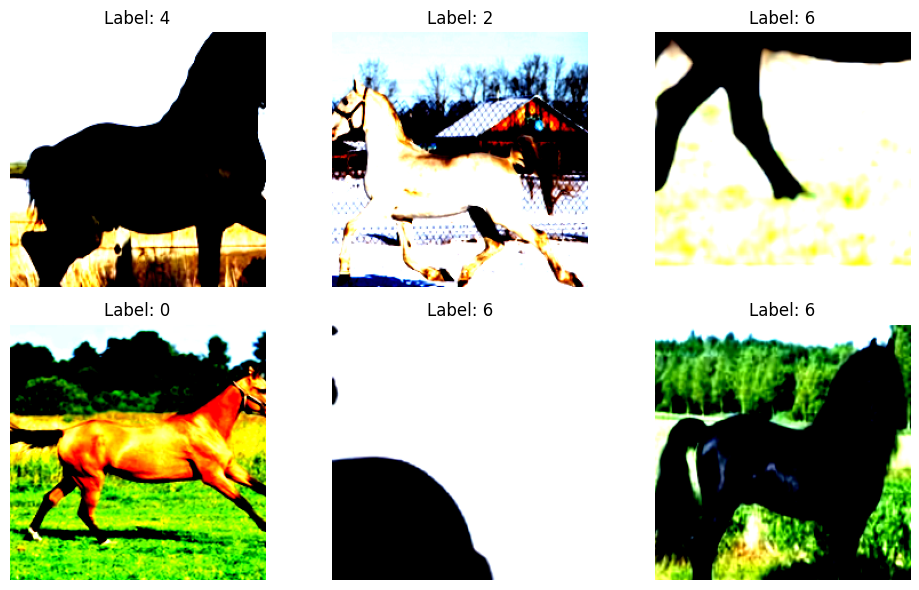

In [60]:
plt.figure(figsize=(10, 6))
for i in range(6):
    img, label = train_dataset[i]  
    img = img.permute(1, 2, 0) 
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### OverSampling Classes 

In [61]:
from torch.utils.data import WeightedRandomSampler

counts = [train_labels.count(i) for i in range(7)]
weights = [1.0 / counts[label] for label in train_labels]
weights = torch.DoubleTensor(weights)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)


In [62]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}


### Train Model Function

In [63]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    import copy, time
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    since = time.time()
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*10)
        
        #training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())
        
        #validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
        
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc.item())
        
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f"Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}\n")
    
    model.load_state_dict(best_model_wts)
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Val Acc: {best_acc:.4f}")
    
    return model, history


### (Transfer Learning) we will use a predefined Model
1. Check archeticture to see what the last layer is
2. Freeze all layers except for last layer 
3. Train the last layer


In [64]:
model_ft = models.resnet18(weights='DEFAULT')

for param in model_ft.parameters():
    param.requires_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 7)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)  
model_ft, history = train_model(model_ft, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
Train Loss: 1.8858 Acc: 0.2239 | Val Loss: 1.7273 Acc: 0.3400

Epoch 2/10
----------
Train Loss: 1.5873 Acc: 0.4542 | Val Loss: 1.4287 Acc: 0.5200

Epoch 3/10
----------
Train Loss: 1.3541 Acc: 0.5693 | Val Loss: 1.1650 Acc: 0.6800

Epoch 4/10
----------
Train Loss: 1.1746 Acc: 0.6375 | Val Loss: 1.0355 Acc: 0.7000

Epoch 5/10
----------
Train Loss: 1.0348 Acc: 0.6652 | Val Loss: 0.9340 Acc: 0.7800

Epoch 6/10
----------
Train Loss: 0.9952 Acc: 0.6674 | Val Loss: 0.8622 Acc: 0.7900

Epoch 7/10
----------
Train Loss: 0.9148 Acc: 0.7249 | Val Loss: 0.8129 Acc: 0.8000

Epoch 8/10
----------
Train Loss: 0.8866 Acc: 0.7292 | Val Loss: 0.7727 Acc: 0.7700

Epoch 9/10
----------
Train Loss: 0.8205 Acc: 0.7463 | Val Loss: 0.7309 Acc: 0.7900

Epoch 10/10
----------
Train Loss: 0.8674 Acc: 0.7271 | Val Loss: 0.7079 Acc: 0.8300

Training complete in 0m 39s
Best Val Acc: 0.8300


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

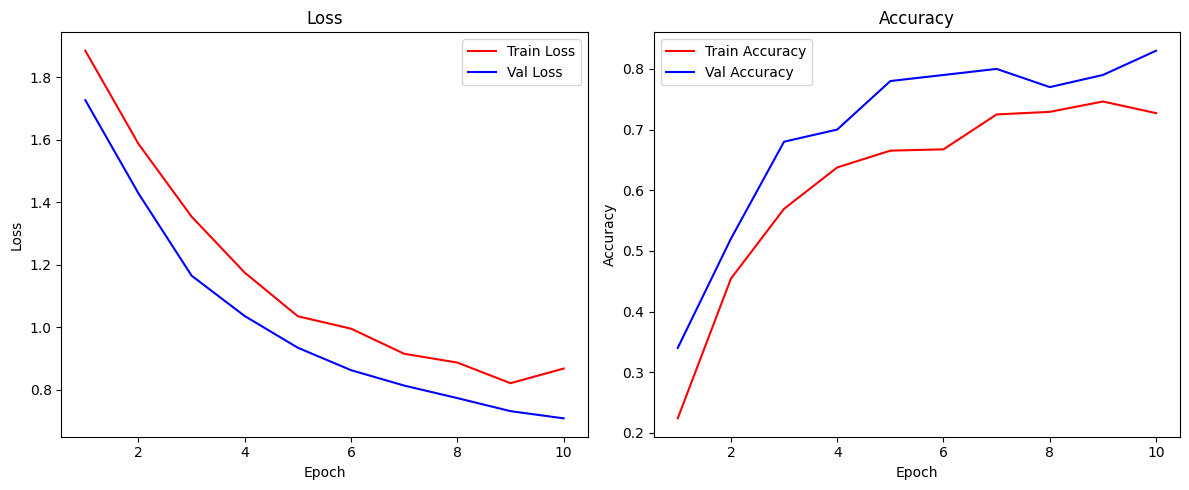

In [65]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], color='red', label='Train Loss')
plt.plot(epochs, history['val_loss'], color='blue', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], color='red', label='Train Accuracy')
plt.plot(epochs, history['val_acc'], color='blue', label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


* Loss: The validation loss is slightly lower than the training loss, which indicates that the model is not overfitting and is generalizing well to unseen data.

* Accuracy: The validation accuracy is higher than the training accuracy, which is a positive sign and shows that the model performs well on the validation set.

* Loss Curve: Both training and validation loss decrease steadily, with validation loss remaining lower, indicating good generalization.

* Accuracy Curve: Validation accuracy remains consistently high, sometimes higher than training accuracy, confirming that the model is learning effectively.

### Display predictions with images

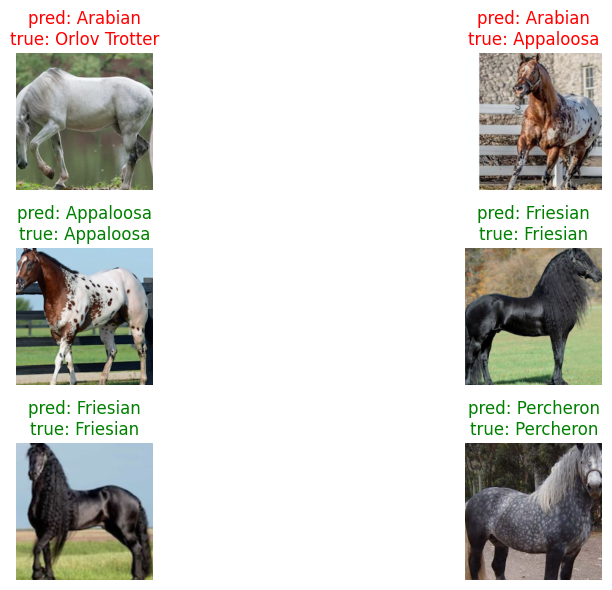

In [66]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

class_names = [
    'Akhal-Teke',     
    'Appaloosa',      
    'Orlov Trotter',  
    'Vladimir Heavy Draft', 
    'Percheron',      
    'Arabian',        
    'Friesian'        
]

def imshow(inp, title=None):
    """Display a Tensor image after unnormalizing."""
    inp = inp.numpy().transpose((1, 2, 0))  
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')
def visualize_model(model, dataloader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 6))

    # Flatten the dataset to access images randomly
    all_inputs = []
    all_labels = []
    for inputs, labels in dataloader:
        all_inputs.append(inputs)
        all_labels.append(labels)
    all_inputs = torch.cat(all_inputs)
    all_labels = torch.cat(all_labels)

    # Pick random indices
    rand_indices = random.sample(range(len(all_inputs)), num_images)

    with torch.no_grad():
        for idx in rand_indices:
            inp = all_inputs[idx].unsqueeze(0).to(device)
            label = all_labels[idx].to(device)

            output = model(inp)
            _, pred = torch.max(output, 1)

            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')

            # Set title color based on correctness
            title_color = 'green' if pred.item() == label.item() else 'red'
            ax.set_title(f'pred: {class_names[pred.item()]}\ntrue: {class_names[label.item()]}',
                         color=title_color)

            imshow(inp.cpu().data[0])

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

visualize_model(model_ft, test_loader, num_images=6)

### test the model on test set

In [67]:
from sklearn.metrics import f1_score

def evaluate_model_f1(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()

    f1 = f1_score(all_labels, all_preds, average='macro') 

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1-score: {f1:.4f}")

    return accuracy, f1

accuracy, f1 = evaluate_model_f1(model_ft, test_loader)


Test Accuracy: 0.7624
Test F1-score: 0.6962


### Load the model

In [68]:
torch.save(model_ft.state_dict(), "horse_classification.pth")


In [69]:

model_ft.load_state_dict(torch.load("horse_classification.pth", map_location=device))

model_ft = model_ft.to(device)
model_ft.eval()

print("Model loaded.")

Model loaded.
